In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 100)
plt.rcParams['figure.figsize'] = (10, 5)

In [15]:
train = pd.read_csv('../data/train.csv')
stores = pd.read_csv('../data/stores.csv')
features = pd.read_csv('../data/features.csv')

train.head(), stores.head(), features.head()

(   Store  Dept        Date  Weekly_Sales  IsHoliday
 0      1     1  2010-02-05      24924.50      False
 1      1     1  2010-02-12      46039.49       True
 2      1     1  2010-02-19      41595.55      False
 3      1     1  2010-02-26      19403.54      False
 4      1     1  2010-03-05      21827.90      False,
    Store Type    Size
 0      1    A  151315
 1      2    A  202307
 2      3    B   37392
 3      4    A  205863
 4      5    B   34875,
    Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
 0      1  2010-02-05        42.31       2.572        NaN        NaN   
 1      1  2010-02-12        38.51       2.548        NaN        NaN   
 2      1  2010-02-19        39.93       2.514        NaN        NaN   
 3      1  2010-02-26        46.63       2.561        NaN        NaN   
 4      1  2010-03-05        46.50       2.625        NaN        NaN   
 
    MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
 0        NaN        NaN        N

In [16]:
for name, df in [('train', train), ('stores', stores), ('features', features)]:
    print(f'—— {name} ——')
    print(df.shape)
    print(df.isna().sum(), '\n')

—— train ——
(421570, 5)
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64 

—— stores ——
(45, 3)
Store    0
Type     0
Size     0
dtype: int64 

—— features ——
(8190, 12)
Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64 



In [17]:
# Ensure date parsed
train['Date'] = pd.to_datetime(train['Date'])
features['Date'] = pd.to_datetime(features['Date'])

# Merge: train + features + stores
df = (train
      .merge(features, on=['Store','Date'], how='left')
      .merge(stores,   on='Store',          how='left')
     )

df.sort_values(['Store','Dept','Date'], inplace=True)
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [18]:
# Fill obvious numeric nulls with reasonable imputations
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in ['CPI','Unemployment','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','Temperature','Size']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

# If IsHoliday exists (bool), coerce to bool
if 'IsHoliday' in df.columns:
    df['IsHoliday'] = df['IsHoliday'].astype(bool)


In [19]:
df['Year']  = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week']  = df['Date'].dt.isocalendar().week.astype(int)
df['Day']   = df['Date'].dt.day

In [20]:
'''
We’ll structure our EDA to answer realistic business questions used by companies:

Overall trend: Are weekly sales increasing, flat, or declining?

Seasonality: Which months/weeks peak?

Store performance: Which stores/departments drive revenue?

Holiday impact: How do holidays affect sales?

Drivers: Do fuel price, CPI, unemployment correlate with sales?

Markdowns: Do markdowns lift sales?
'''

'\nWe’ll structure our EDA to answer realistic business questions used by companies:\n\nOverall trend: Are weekly sales increasing, flat, or declining?\n\nSeasonality: Which months/weeks peak?\n\nStore performance: Which stores/departments drive revenue?\n\nHoliday impact: How do holidays affect sales?\n\nDrivers: Do fuel price, CPI, unemployment correlate with sales?\n\nMarkdowns: Do markdowns lift sales?\n'

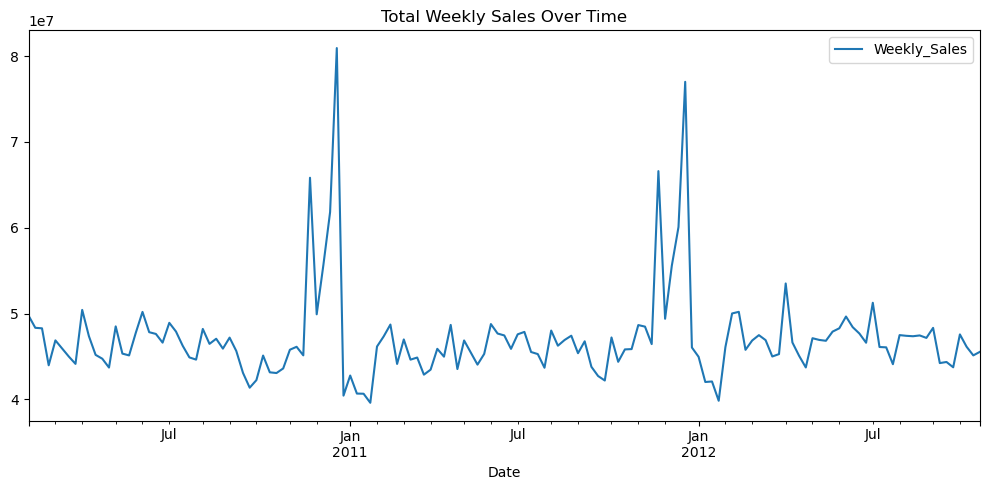

In [21]:
# Weekly sales trend
weekly = df.groupby('Date', as_index=False)['Weekly_Sales'].sum()
ax = weekly.plot(x='Date', y='Weekly_Sales', title='Total Weekly Sales Over Time')
plt.tight_layout()
plt.savefig('../assets/overall_weekly_sales.png', dpi=150)
plt.show()

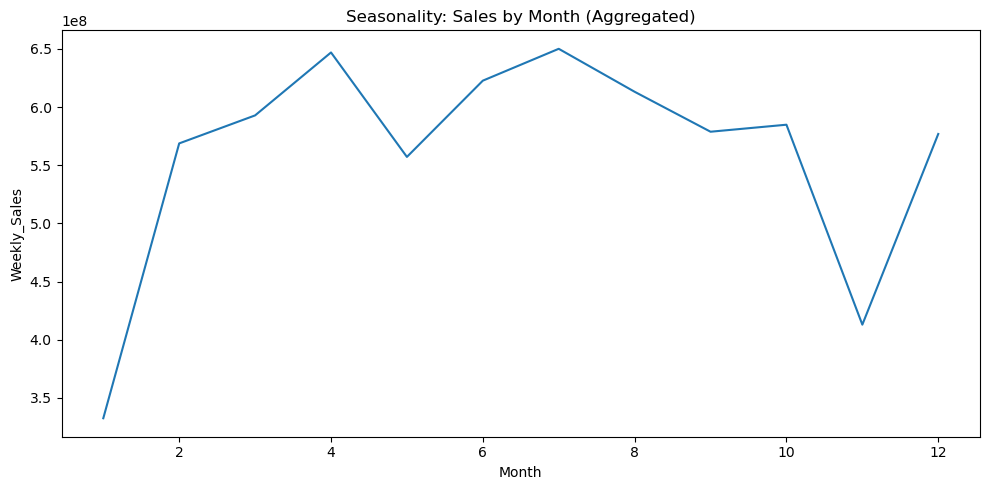

In [22]:
# seaonality: Sales by Month
month_agg = df.groupby('Month', as_index=False)['Weekly_Sales'].sum()
ax = sns.lineplot(data=month_agg, x='Month', y='Weekly_Sales')
ax.set_title('Seasonality: Sales by Month (Aggregated)')
plt.tight_layout()
plt.savefig('../assets/seasonality_month.png', dpi=150)
plt.show()

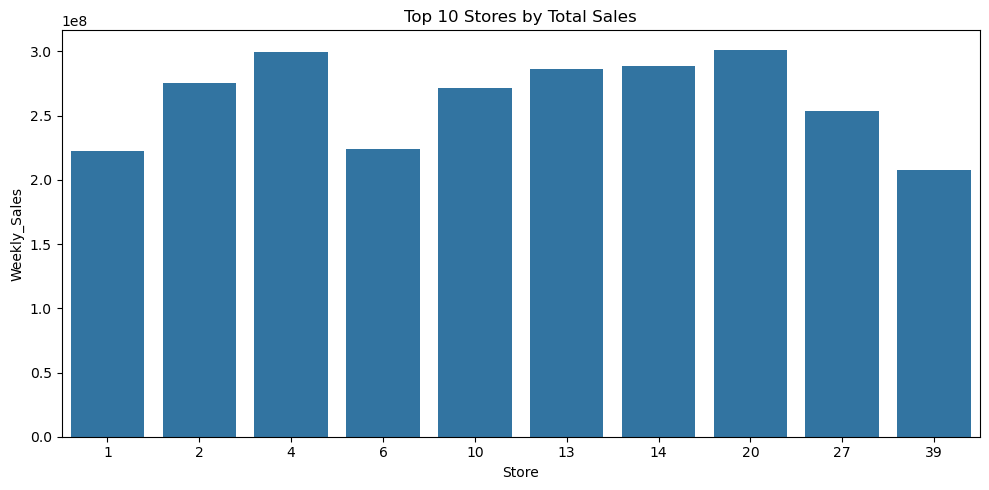

In [ ]:
# Store performance: Top 10 Stores by Total Sales
store_sales = df.groupby('Store', as_index=False)['Weekly_Sales'].sum().sort_values('Weekly_Sales', ascending=False).head(10)
sns.barplot(data=store_sales, x='Store', y='Weekly_Sales')
plt.title('Top 10 Stores by Total Sales')
plt.tight_layout()
plt.savefig('../assets/top_stores.png', dpi=150)
plt.show()

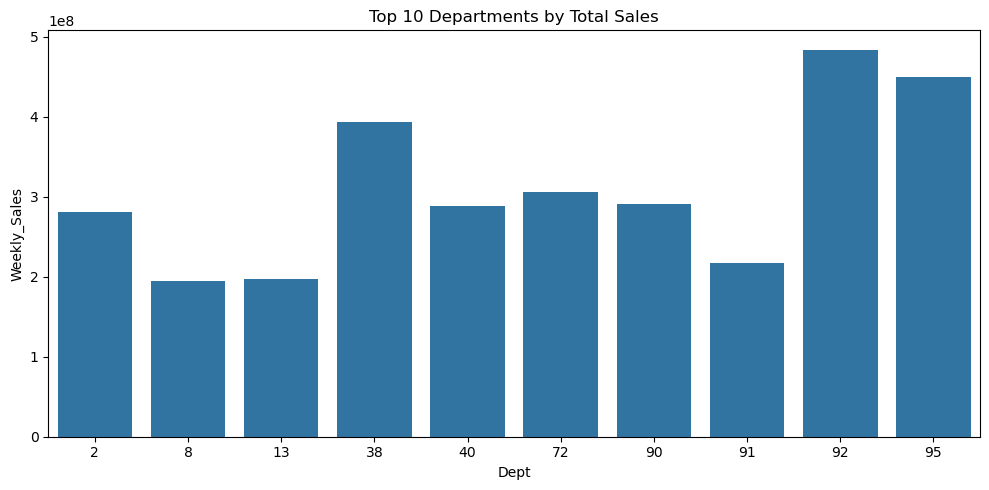

In [24]:
# Department performance: Top 10 Departments by Total Sales
dept_sales = df.groupby('Dept', as_index=False)['Weekly_Sales'].sum().sort_values('Weekly_Sales', ascending=False).head(10)
sns.barplot(data=dept_sales, x='Dept', y='Weekly_Sales')
plt.title('Top 10 Departments by Total Sales')
plt.tight_layout()
plt.savefig('../assets/top_depts.png', dpi=150)
plt.show()

In [25]:
# Holiday vs Non-Holiday Sales.
if 'IsHoliday' in df.columns:
    holiday_compare = df.groupby('IsHoliday', as_index=False)['Weekly_Sales'].mean()
    sns.barplot(data=holiday_compare, x='IsHoliday', y='Weekly_Sales')
    plt.title('Average Weekly Sales: Holiday vs Non-Holiday')
    plt.tight_layout()
    plt.savefig('../assets/holiday_effect.png', dpi=150)
    plt.show()

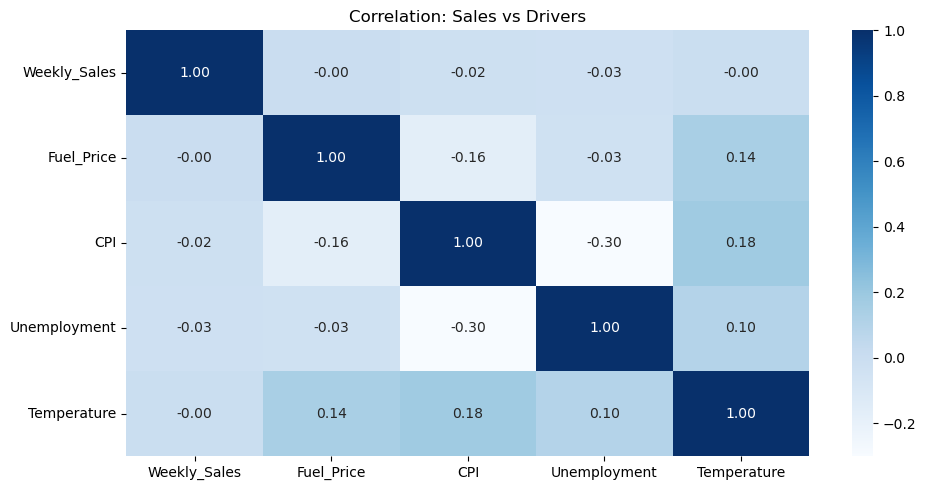

In [26]:
# Correlation with Macro Drivers.
candidate_cols = [c for c in ['Weekly_Sales','Fuel_Price','CPI','Unemployment','Temperature'] if c in df.columns]
corr = df[candidate_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues')
plt.title('Correlation: Sales vs Drivers')
plt.tight_layout()
plt.savefig('../assets/corr_drivers.png', dpi=150)
plt.show()